# 3f. Word2Vec

Now, I will use Word2Vec modeling for generating word embedding to map words to vectors of numbers. The basic idea of word embedding is words that occur in similar context tend to be closer to each other in vector space.   

Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.

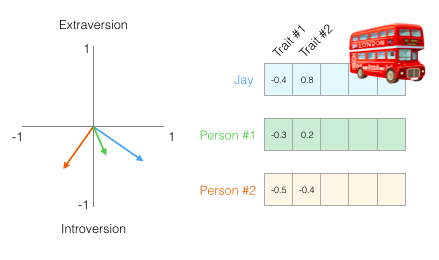

Word2Vec consists of models for generating word embedding. These models are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures :

CBOW (Continuous Bag of Words) : CBOW model predicts the current word given context words within specific window. The input layer contains the context words and the output layer contains the current word. The hidden layer contains the number of dimensions in which we want to represent current word present at the output layer.

Skip Gram : Skip gram predicts the surrounding context words within specific window given current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer.

For generating word vectors in Python, modules needed are nltk and gensim.

In [20]:
# import necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import gensim
import nltk
import keras

from gensim.models.word2vec import Word2Vec
from nltk import word_tokenize
#nltk.download('stopwords')
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import re

from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

import warnings
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [21]:
# read the data into a DataFrame
df = pd.read_csv('2_explored.csv', index_col=0)

In [22]:
cleaned_values = df.clean_text.values
cleaned_values.shape

(1063,)

I will train the data on one set and test on a set not seen before to reduce bias. I need to do my own train test split here:

In [23]:
X_cleaned_values = cleaned_values
X_train_cleaned_values = cleaned_values[685:]
X_test_cleaned_values = cleaned_values[:685]

rating_values = df.rating.values
y = rating_values
y_train = rating_values[685:]
y_test = rating_values[:685]

In [24]:
X_tokenized = [nltk.word_tokenize(text) for text in X_cleaned_values]
X_train_tokenized = [nltk.word_tokenize(text) for text in X_train_cleaned_values]
X_test_tokenized = [nltk.word_tokenize(text) for text in X_test_cleaned_values]

In [25]:
# train word2vec model using gensim
w2v = Word2Vec(X_train_tokenized, sg=1, window=3, size=100,
                 min_count=1, workers=3, iter=50 , sample=0.01)

The following function helps me compute averaged word vector representations for any corpus of text documents.

In [26]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

I can use this function to generate averaged word vector representations on our dataset.

In [27]:
# generate averaged word vector features from word2vec model
X = averaged_word2vec_vectorizer(corpus=X_tokenized, model=w2v, num_features=100) 
X_train = averaged_word2vec_vectorizer(corpus=X_train_tokenized, model=w2v, num_features=100)
X_test = averaged_word2vec_vectorizer(corpus=X_test_tokenized, model=w2v, num_features=100)

I will define a function to better visualize the test results given by the confusion matrix.

In [28]:
# Function for plotting a good-looking confusion matrix

def plot_confusion_matrix(y_test, y_pred, title, color):
    
    '''This function takes as input: 
            a target test variable y_test (pandas series of type integer), 
            a target predicted variable y_pred (pandas series of type integer), 
            a colormap color (string) and 
            a title (string). 
        It plots a confusion matrix of y_test and y_pred with the input colormap.
    '''
    
    cm_ratio = np.round(confusion_matrix(y_test, y_pred) / len(y_test), decimals=2)
    plt.clf()
    plt.style.use('classic')
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(cm_ratio, interpolation='nearest', cmap=color)
    classNames = ['Neg_Review',' Pos_Review']
    plt.title(title, fontsize=20)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, fontsize=15)
    plt.yticks(tick_marks, classNames, fontsize=15, rotation=90)
    s = [['TNR','FPR'], ['FNR', 'TPR']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm_ratio[i][j]), fontsize=15, 
                 fontweight='bold', horizontalalignment="center")
    return plt.show()

I will code a function to facilitate fitting a classifier to training data, predicting on test data, printing the accuracy and cross validation scores along with the classification report and showing the confusion matrix results using the function above.

In [29]:
def fit_predict_print_plot(my_classifier, my_title):
    
    '''This function takes an instance of a classifier and my_title string, fits to training data, 
    predicts on test data, prints and plots the results'''
    
    # Fitting the classifier to the training data split
    my_classifier.fit(X_train, y_train)

    # Predicting on the test split
    y_predicted = my_classifier.predict(X_test)

    # Checking the accuracy and the cross validation scores
    print('accuracy on training set: ', my_classifier.score(X_train, y_train))
    print('accuracy on test set: ', accuracy_score(y_test, y_predicted))
    print('croos validation score on whole data set: ', 
          np.mean(cross_val_score(my_classifier, X, y, cv = 5)), '\n')

    # Checking the results with the Classification report
    print (classification_report(y_test, y_predicted))
    
    # Checking the results visually by Plotting the confusion matrix with "plot_confusion_matrix" function I defined above
    plot_confusion_matrix(y_test, y_predicted, 
                      title = my_title, 
                      color=plt.cm.Set3)
    return(y_predicted)

Starting with logistic regression, I will use different classification algorithms to predict the ratings of the reviews. Namely: Logistic Regression, K-Nearest Neighbors, Linear Support Vector Machines (SVM), Kernel SVM, Naive Bayes, Decision Trees, Random Forest, AdaBoost, Gradient Boosting, Stochastic Gradient Boosting, Extreme Gradient Boosting (XGBoost) and CatBoost.

## 3.1. Logistic Regression

accuracy on training set:  0.7645502645502645
accuracy on test set:  0.7985401459854015
croos validation score on whole data set:  0.78927274337851 

              precision    recall  f1-score   support

           0       0.60      0.06      0.12       141
           1       0.80      0.99      0.89       544

    accuracy                           0.80       685
   macro avg       0.70      0.53      0.50       685
weighted avg       0.76      0.80      0.73       685



<Figure size 640x480 with 0 Axes>

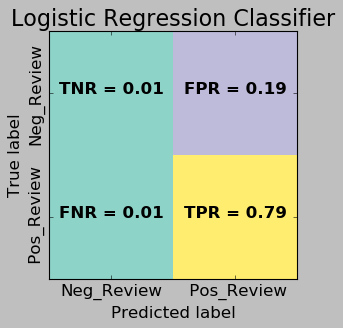

In [30]:
# Instantiating the logistic regression classifier logreg
logreg = LogisticRegression(penalty = 'l2', C = 1, solver='newton-cg', random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_logreg = fit_predict_print_plot(logreg, 'Logistic Regression Classifier')

## 3.2. K-Neighbors Classifier

accuracy on training set:  0.843915343915344
accuracy on test set:  0.7635036496350365
croos validation score on whole data set:  0.7845646204269643 

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       141
           1       0.85      0.86      0.85       544

    accuracy                           0.76       685
   macro avg       0.63      0.63      0.63       685
weighted avg       0.76      0.76      0.76       685



<Figure size 640x480 with 0 Axes>

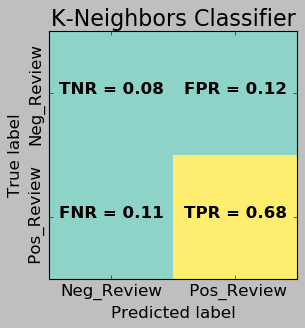

In [31]:
# Instantiating the KNeighborsClassifier knn
knn = KNeighborsClassifier(n_neighbors=5)

# Calling the fit_predict_print_plot function I defined above
y_predicted_knn = fit_predict_print_plot(knn, 'K-Neighbors Classifier')

## 3.3. Linear SVM

accuracy on training set:  0.7433862433862434
accuracy on test set:  0.7941605839416058
croos validation score on whole data set:  0.7751660908849323 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.79      1.00      0.89       544

    accuracy                           0.79       685
   macro avg       0.40      0.50      0.44       685
weighted avg       0.63      0.79      0.70       685



<Figure size 640x480 with 0 Axes>

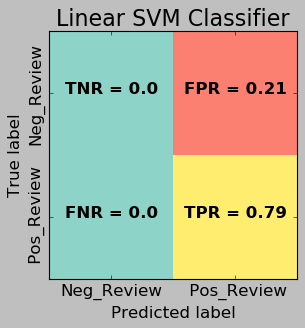

In [32]:
# Instantiating the KNeighborsClassifier knn
l_svm = SVC(kernel='linear', random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_l_svm = fit_predict_print_plot(l_svm, 'Linear SVM Classifier')

## 3.4. Kernel SVM

accuracy on training set:  0.7433862433862434
accuracy on test set:  0.7941605839416058
croos validation score on whole data set:  0.7761094871113473 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.79      1.00      0.89       544

    accuracy                           0.79       685
   macro avg       0.40      0.50      0.44       685
weighted avg       0.63      0.79      0.70       685



<Figure size 640x480 with 0 Axes>

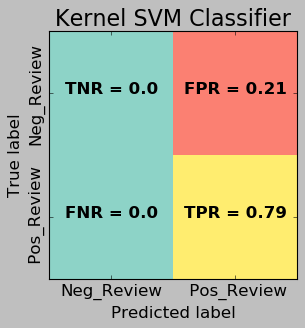

In [33]:
# Instantiating the KNeighborsClassifier knn
k_svm = SVC(kernel='rbf', gamma='auto')

# Calling the fit_predict_print_plot function I defined above
y_predicted_k_svm = fit_predict_print_plot(k_svm, 'Kernel SVM Classifier')

## 3.5. Decision Tree Classifier

accuracy on training set:  0.8253968253968254
accuracy on test set:  0.7605839416058394
croos validation score on whole data set:  0.7751528036141376 

              precision    recall  f1-score   support

           0       0.42      0.46      0.44       141
           1       0.86      0.84      0.85       544

    accuracy                           0.76       685
   macro avg       0.64      0.65      0.64       685
weighted avg       0.77      0.76      0.76       685



<Figure size 640x480 with 0 Axes>

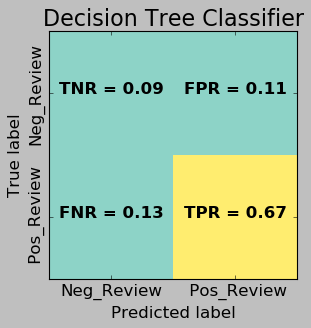

In [34]:
# Instantiating the Decision Tree Classifier dt
dt = DecisionTreeClassifier(max_depth = 6, max_features = 0.6, 
                             min_samples_leaf = 0.08, random_state = 123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_dt = fit_predict_print_plot(dt, 'Decision Tree Classifier')

## 3.6. Random Forest 

accuracy on training set:  1.0
accuracy on test set:  0.8102189781021898
croos validation score on whole data set:  0.8024404287359376 

              precision    recall  f1-score   support

           0       0.55      0.44      0.49       141
           1       0.86      0.91      0.88       544

    accuracy                           0.81       685
   macro avg       0.71      0.67      0.69       685
weighted avg       0.80      0.81      0.80       685



<Figure size 640x480 with 0 Axes>

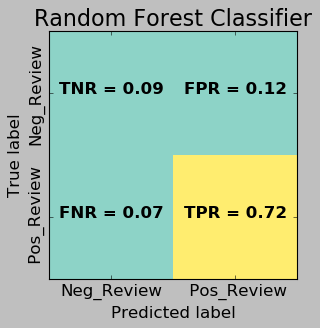

In [35]:
# Instantiating the Random Forest Classifier rf
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_rf = fit_predict_print_plot(rf, 'Random Forest Classifier')

## 3.7. AdaBoosting

accuracy on training set:  1.0
accuracy on test set:  0.7941605839416058
croos validation score on whole data set:  0.7930418991939056 

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       141
           1       0.86      0.89      0.87       544

    accuracy                           0.79       685
   macro avg       0.68      0.65      0.66       685
weighted avg       0.78      0.79      0.79       685



<Figure size 640x480 with 0 Axes>

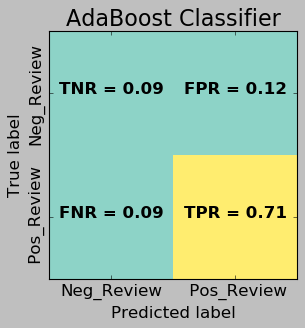

In [36]:
# Instantiating the AdaBoost Classifier adb
adb = AdaBoostClassifier(base_estimator = dt, n_estimators = 100)

# Calling the fit_predict_print_plot function I defined above
y_predicted_adb = fit_predict_print_plot(adb, 'AdaBoost Classifier')

## 3.8. GradientBoosting

accuracy on training set:  1.0
accuracy on test set:  0.8160583941605839
croos validation score on whole data set:  0.8005802108246967 

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       141
           1       0.86      0.92      0.89       544

    accuracy                           0.82       685
   macro avg       0.72      0.67      0.69       685
weighted avg       0.80      0.82      0.81       685



<Figure size 640x480 with 0 Axes>

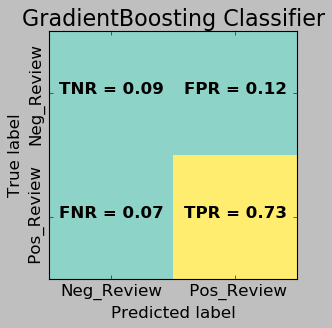

In [37]:
# Instantiating the GradientBoosting Classifier gbt
gbt = GradientBoostingClassifier(n_estimators=300, max_depth =3, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_gbt = fit_predict_print_plot(gbt, 'GradientBoosting Classifier')

## 3.9. Stochastic Gradient Boosting

accuracy on training set:  1.0
accuracy on test set:  0.8087591240875912
croos validation score on whole data set:  0.8193949862698201 

              precision    recall  f1-score   support

           0       0.55      0.40      0.46       141
           1       0.85      0.92      0.88       544

    accuracy                           0.81       685
   macro avg       0.70      0.66      0.67       685
weighted avg       0.79      0.81      0.80       685



<Figure size 640x480 with 0 Axes>

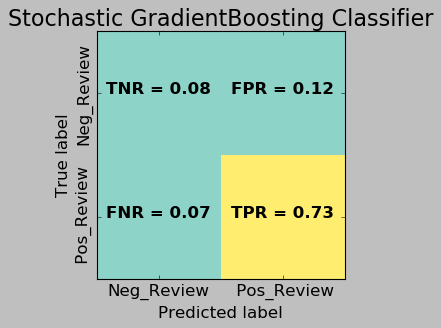

In [38]:
# Instantiating the Stochastic GradientBoosting Classifier sgbt
sgb = GradientBoostingClassifier(max_depth=3, subsample=0.8, 
                                   max_features=0.2, n_estimators=300, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_sgb = fit_predict_print_plot(sgb, 'Stochastic GradientBoosting Classifier')

## 3.10. XGBoost

accuracy on training set:  0.9973544973544973
accuracy on test set:  0.8116788321167884
croos validation score on whole data set:  0.8034192576844716 

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       141
           1       0.86      0.92      0.89       544

    accuracy                           0.81       685
   macro avg       0.71      0.66      0.68       685
weighted avg       0.80      0.81      0.80       685



<Figure size 640x480 with 0 Axes>

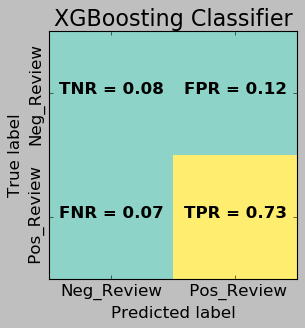

In [39]:
# Instantiating the XGBoosting Classifier xgb
xgb = XGBClassifier(random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_xgb = fit_predict_print_plot(xgb, 'XGBoosting Classifier')

## 3.11. CatBoost

accuracy on training set:  1.0
accuracy on test set:  0.8
croos validation score on whole data set:  0.8090397732305785 

              precision    recall  f1-score   support

           0       0.52      0.41      0.46       141
           1       0.86      0.90      0.88       544

    accuracy                           0.80       685
   macro avg       0.69      0.66      0.67       685
weighted avg       0.79      0.80      0.79       685



<Figure size 640x480 with 0 Axes>

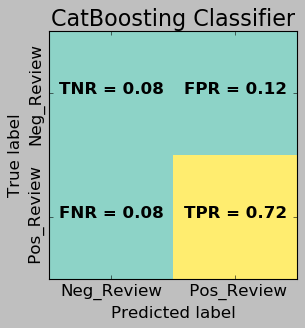

In [40]:
# Instantiating the Cat Boosting Classifier cb
cb = CatBoostClassifier(verbose=False, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_cb = fit_predict_print_plot(cb, 'CatBoosting Classifier')

## 3.12. Naive Bayes

accuracy on training set:  0.7433862433862434
accuracy on test set:  0.7941605839416058
croos validation score on whole data set:  0.7761094871113473 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.79      1.00      0.89       544

    accuracy                           0.79       685
   macro avg       0.40      0.50      0.44       685
weighted avg       0.63      0.79      0.70       685



<Figure size 640x480 with 0 Axes>

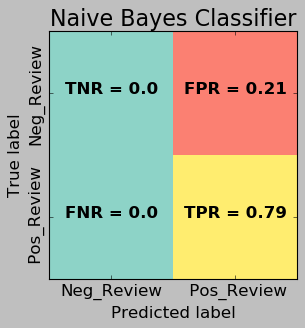

In [42]:
X_train = abs(X_train) # due to model not accepting negative inputs
X = abs(X)

# Instantiating the Naive Bayes Classifier nb
nb = MultinomialNB()

# Calling the fit_predict_print_plot function I defined above
y_predicted_nb = fit_predict_print_plot(nb, 'Naive Bayes Classifier')

## Comparison of results

I will use two functions to build a DataFrame for comparison.

In [49]:
# Function for converting the classification report results to a dataframe

def get_classification_report(y_true, y_pred):
    
    '''This function takes in true (y_true) and predicted (y_pred) values of a target variable and produces 
    a classification report '''
    
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)

    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary), index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

In [50]:
# Function for adding explanatory columns and organizing the dataframe

def build_comparison_matrix(y_test, y_pred, algorithm, vector):
    
    '''This function builds a comparison matrix as a DataFrame, given target variable test and prediction values
    as pandas Series of integers, name of the algorithm of type string and name of the word vectorizer as string'''
    
    df = get_classification_report(y_test, y_pred)
    df['class']=['neg_review', 'pos_review', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = algorithm
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    
    return df

In [51]:
#For loop using above functions to build CountVectorizing results table

frames = [] # empty list for collecting dataframes

y_preds = [y_predicted_logreg, y_predicted_knn, y_predicted_l_svm, y_predicted_k_svm, y_predicted_nb, y_predicted_dt,
                y_predicted_rf, y_predicted_adb, y_predicted_gbt, y_predicted_sgb, y_predicted_xgb, y_predicted_cb] 

labels = ['LogReg', 'KNN', 'LSVM', 'KSVM', 'NBayes', 'DTree', 
             'RForest', 'ABoost', 'GBoost', 'SGBoost', 'XGBoost', 'CBoost'] 

vector = 'Word2Vec_ML'

for y_pred, label in zip(y_preds, labels):
    df = build_comparison_matrix(y_test, y_pred, label, vector)
    frames.append(df)

# concatenating all dataframes
df_w2v = pd.concat(frames)

df_w2v2 = df_w2v.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [52]:
df_w2v2

precision    recall  f1-score  \
vectorizer  model   accuracy class                                       
Word2Vec_ML LogReg  0.798540 neg_review   0.600000  0.063830  0.115385   
                             pos_review   0.802985  0.988971  0.886326   
                             average      0.761203  0.798540  0.727636   
            KNN     0.763504 neg_review   0.421053  0.397163  0.408759   
                             pos_review   0.846014  0.858456  0.852190   
                             average      0.758541  0.763504  0.760914   
            LSVM    0.794161 neg_review   0.000000  0.000000  0.000000   
                             pos_review   0.794161  1.000000  0.885273   
                             average      0.630691  0.794161  0.703049   
            KSVM    0.794161 neg_review   0.000000  0.000000  0.000000   
                             pos_review   0.794161  1.000000  0.885273   
                             average      0.630691  0.794161  0.703049   
            NBayes  0.794161 neg_review   0.000000  0.000000  0.000000   
                             pos_review   0.794161  1.000000  0.885273   
                             average      0.630691  0.794161  0.703049   
            DTree   0.760584 neg_review   0.424837  0.460993  0.442177   
                             pos_review   0.857143  0.838235  0.847584   
                             average      0.768157  0.760584  0.764135   
            RForest 0.810219 neg_review   0.548673  0.439716  0.488189   
                             pos_review   0.861888  0.906250  0.883513   
                             average      0.797416  0.810219  0.802139   
            ABoost  0.794161 neg_review   0.500000  0.418440  0.455598   
                             pos_review   0.855379  0.891544  0.873087   
                             average      0.782228  0.794161  0.787152   
            GBoost  0.816058 neg_review   0.570093  0.432624  0.491935   
                             pos_review   0.861592  0.915441  0.887701   
                             average      0.801590  0.816058  0.806236   
            SGBoost 0.808759 neg_review   0.549020  0.397163  0.460905   
                             pos_review   0.854202  0.915441  0.883762   
                             average      0.791384  0.808759  0.796722   
            XGBoost 0.811679 neg_review   0.557692  0.411348  0.473469   
                             pos_review   0.857143  0.915441  0.885333   
                             average      0.795504  0.811679  0.800555   
            CBoost  0.800000 neg_review   0.517857  0.411348  0.458498   
                             pos_review   0.855148  0.900735  0.877350   
                             average      0.785721  0.800000  0.791134   

                                         support  
vectorizer  model   accuracy class                
Word2Vec_ML LogReg  0.798540 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            KNN     0.763504 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            LSVM    0.794161 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            KSVM    0.794161 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            NBayes  0.794161 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            DTree   0.760584 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            RForest 0.810219 neg_review    141.0  
                             pos_review    544.0  
                             average       685.0  
            ABoost  0.794161 neg_review    141.0  
    

### Function for plotting F1 Scores of ML models

In [53]:
def f1_score_bar_plot(df, category, title):

    '''This function plots F1 scores from the given DataFrame and class'''
    
    plt.style.use('seaborn-pastel')
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('blue')
    b_plot[z].set_color('magenta')
    
    for i,v in enumerate(y_round):
        plt.text(i-.2, 0.018, str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean, ls='--', color='k', label=y_mean)
    plt.title(title)
    plt.legend(loc='upper right')
    
    return plt.show()

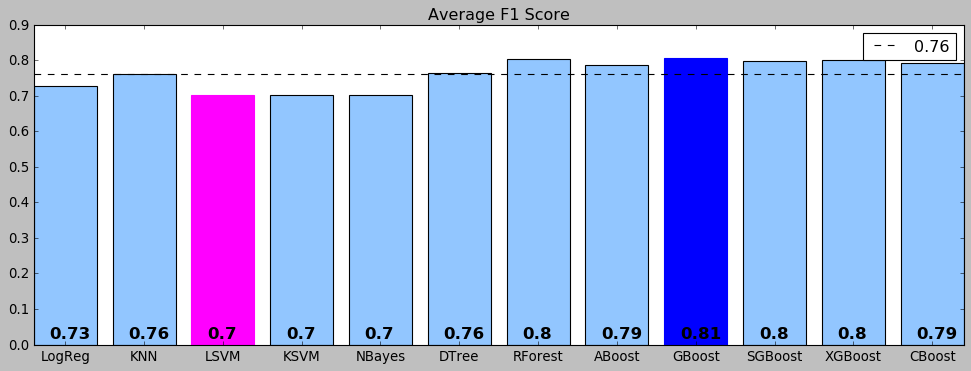

In [54]:
# Plotting F1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_w2v, category='average', title= "Average F1 Score")

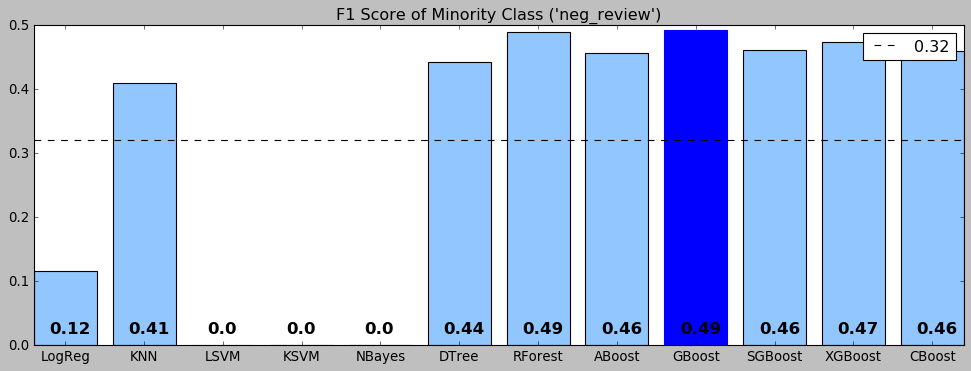

In [55]:
# Plotting f1 score of minority class ('neg_review') with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_w2v, category='neg_review', title= "F1 Score of Minority Class ('neg_review')")

- The best scores using Word2Vec with machine learning models, both in average and minority class F1 score was made by Gradient Boosting: 0.81 and 0.49 respectively.  
- Random Forest also has the minority score of 0.49, but the average score is lower (0.8).
- LSVM, KSVM and Naive Bayes share the lowest average score of 0.7 and minority score of 0. 
- I will save the results for further comparison. 

In [56]:
df_w2v2.to_csv('3g_Word2Vec_ML.csv', sep=',', encoding='utf-8')